# TRADITIONAL ML IMPLEMENTATION

## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings(action='ignore')

import re
import json
import time

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer

import pickle
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
import xgboost as xgb

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from wordcloud import WordCloud
from collections import Counter

In [2]:
df = pd.read_csv('../data/OPTION2_joined_coursework_dataset_banking_final.csv')

In [3]:
df

,text,label,query_index
0,Can I automatically top-up when traveling?,top_up_queries_or_issues,526cd7f17526
1,What kind of fiat currency can I used for hold...,other,f3cf7343067e
2,I did not get the item I ordered. How should ...,other,9a19501c3a3c
3,Freeze my account it's been hacked.,needs_troubleshooting,d76b07db8cf8
4,is there a reason that my payment didnt go thr...,other,bd95ba09a18d
...,...,...,...
14190,Can you tell me what the disposable cards are ...,card_queries_or_issues,bd6df98cc746
14191,The ATM won't give me my card back. I need it ...,card_queries_or_issues,e6197a1334b3
14192,Can you please tell me why my card payments ar...,card_queries_or_issues,b922a2a5f687
14193,The rate for a currency exchange was wrong whe...,needs_troubleshooting,cb1ed2c3ca95


In [4]:
df.shape

(14195, 3)

In [5]:
df.columns

Index(['text', 'label', 'query_index'], dtype='object')

In [6]:
df['label'].value_counts()

other                       5036
needs_troubleshooting       4305
card_queries_or_issues      2598
top_up_queries_or_issues    1684
Other                         21
Card_queries_or_issues        12
Top_up_queries_or_issues      11
Needs_troubleshooting          7
Name: label, dtype: int64

### We have to transform into 4 classes in total “card queries or issues”, “needs troubleshooting”, “top up queries or issues”, “other” 

In [7]:
df['label'] = df['label'].str.lower()

In [8]:
df['label'].value_counts()

other                       5057
needs_troubleshooting       4312
card_queries_or_issues      2610
top_up_queries_or_issues    1695
Name: label, dtype: int64

In [9]:
pd.DataFrame(df['text'].value_counts())

,text
#,68
I topped up but the app did not accept it.,3
How do I know if my top up was unsuccessful?,3
"Oh my goodness, my card has been declined twice at ATM! I tried two different ATM, but each one declined my card! Can you tell me what's going on with my account?",3
I don't understand where this debit came from and want it removed.,3
...,...
My statement shows different transaction times.,1
What are the steps I need to take to cancel a transaction?,1
after i got married i need to change my name,1
I still have not received an answer as to why I was charged $1.00 in a transaction?,1


In [10]:
df[df['text'] == '#']['label'] = df[df['text'] == '#']['label'].value_counts().idxmax()

In [11]:
highest_count = df[df['text'] == '#']['label'].value_counts().idxmax()
df.loc[df['text'] == '#', 'label'] = highest_count

## Dealing with Null Values

In [12]:
df.isna().sum()

text             0
label          521
query_index      0
dtype: int64

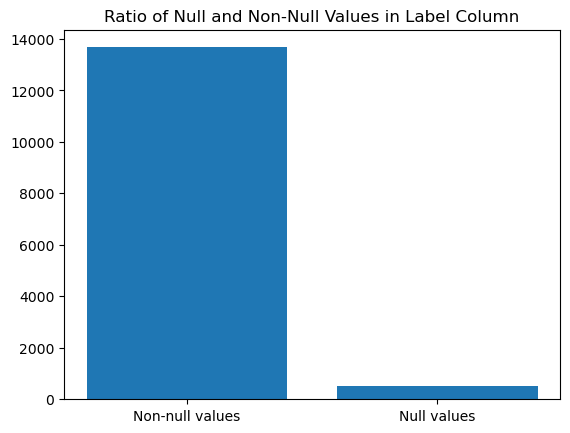

In [13]:
# calculate the count of null and non-null values
null_count = df['label'].isnull().sum()
non_null_count = df['label'].notnull().sum()

plt.bar(['Non-null values', 'Null values'], [non_null_count, null_count])
plt.title('Ratio of Null and Non-Null Values in Label Column')
plt.show()

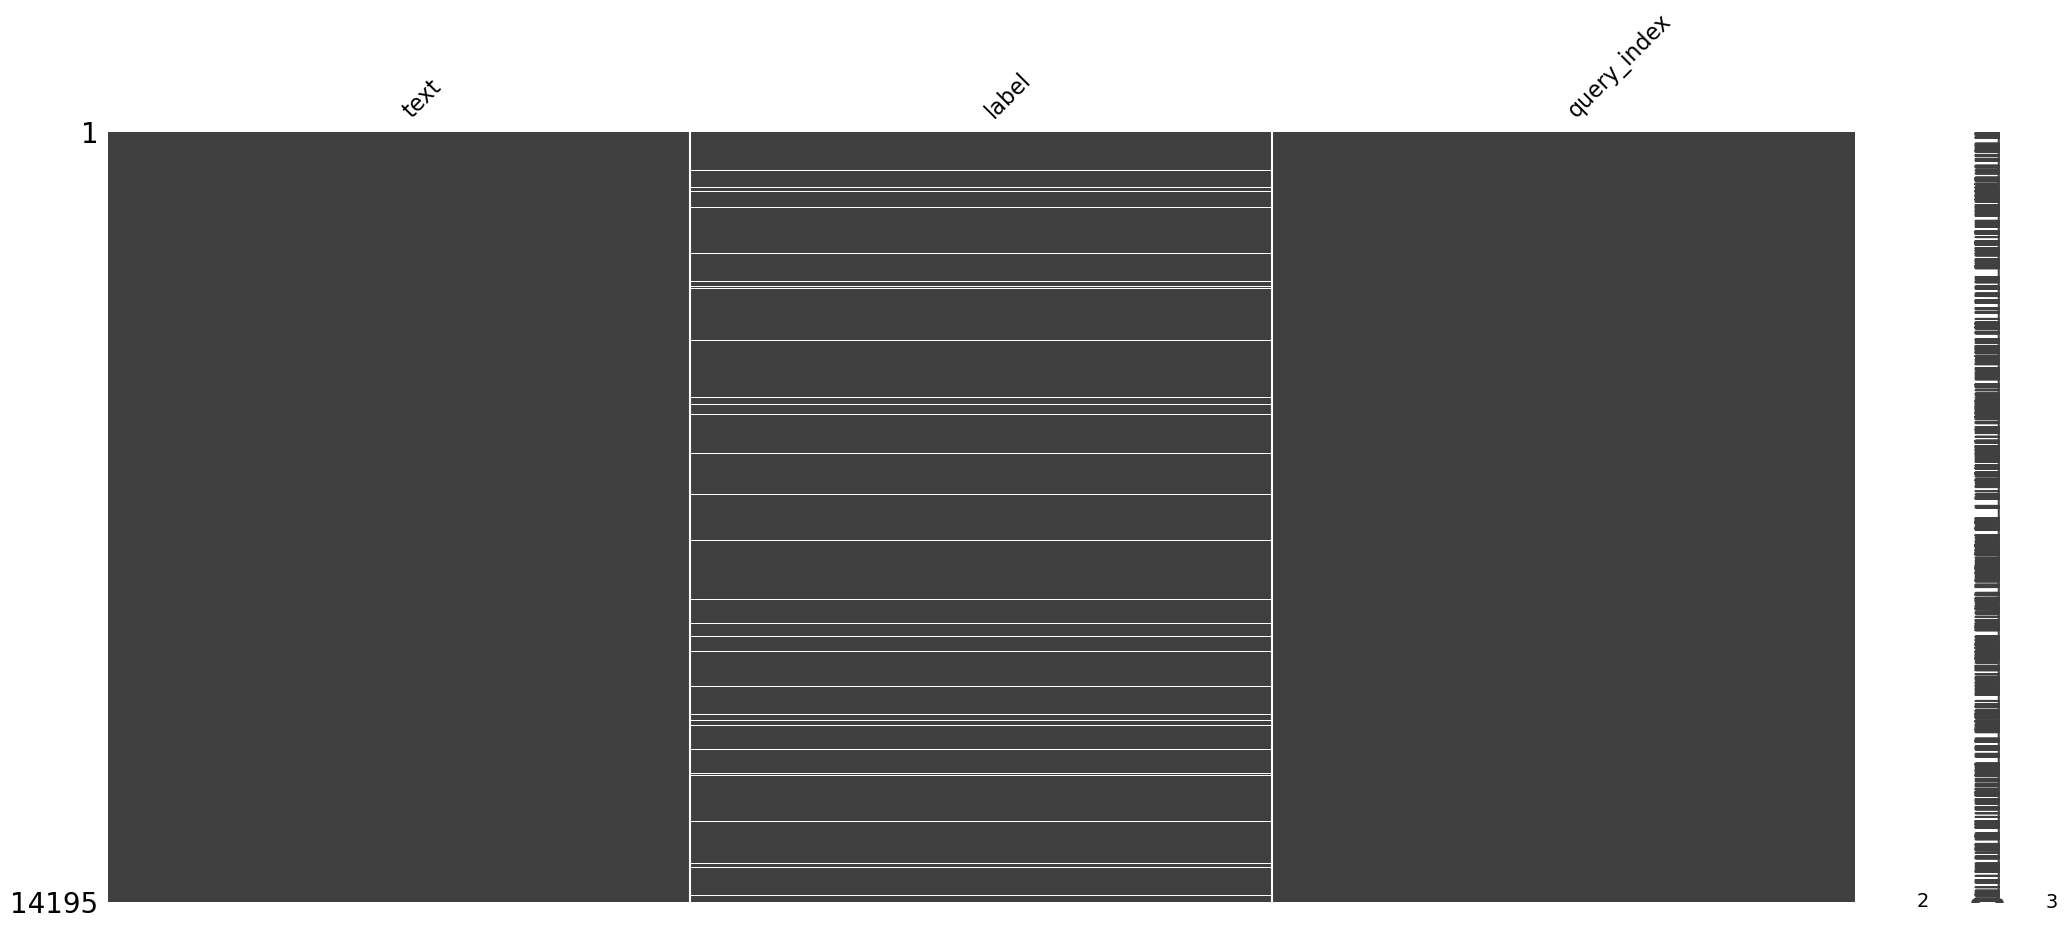

In [14]:
import missingno as msno

msno.matrix(df)
plt.show()

# Visualize missing data in the dataset, including the location 
# and distribution of missing data across columns and rows.

### The above plots visualize the missing data.

In [15]:
df[df['label'].isna()]

,text,label,query_index
17,What do you charge to top up US cards?,NaN,f9ct7333337b
22,I did a transfer to my account but it doesn't ...,NaN,a85ta60fdb59
43,I'm not recognizing the card payment.,NaN,f55t70c7ee03
52,Is it okay to use a bank card to top up,NaN,c72t8fdedfc9
99,Why is there an extra fee on my statement?,NaN,ee0t3820e035
...,...,...,...
14131,When did you start charging to make a withdraw...,NaN,8c8t86b69685
14140,Is there a fee to add money to an internationa...,NaN,f1dt07d4aad8
14155,My money transaction hasn't arrived.,NaN,2b4td3854067
14177,I want to get some cash from the ATM using my ...,NaN,0fdtb1ed8321


In [16]:
# There are text columns that are duplicated but having the label values as NaN

In [17]:
df[df['text'] == 'What do you charge to top up US cards?']

,text,label,query_index
17,What do you charge to top up US cards?,NaN,f9ct7333337b
7924,What do you charge to top up US cards?,top_up_queries_or_issues,f9c07333337b


In [18]:
text_duplicates = df[df.duplicated(subset=['text'], keep=False)]

In [19]:
text_duplicates

,text,label,query_index
17,What do you charge to top up US cards?,NaN,f9ct7333337b
22,I did a transfer to my account but it doesn't ...,NaN,a85ta60fdb59
31,Is there a charge for exchanging foreign curre...,other,a3868d3af8da
39,Hello I made a bank transfer couple hours ago ...,needs_troubleshooting,1612042a2d27
43,I'm not recognizing the card payment.,NaN,f55t70c7ee03
...,...,...,...
14171,Someone else used my card!,needs_troubleshooting,4a9ac2ff2976
14174,Why was money taken for a transfer?,other,62ff235434bf
14177,I want to get some cash from the ATM using my ...,NaN,0fdtb1ed8321
14188,My transfer was declined. What might the reaso...,NaN,aeet3c64060d


In [20]:
sorted_text_duplicates = text_duplicates.sort_values(by=['text'])

In [21]:
sorted_text_duplicates

,text,label,query_index
11294,\nDo I need to go to a physical bank to change...,other,bd266914309f
12851,\nDo I need to go to a physical bank to change...,other,bd266914309f
12814,\nWhere can I use my card?,card_queries_or_issues,8c5e2792341b
4211,\nWhere can I use my card?,card_queries_or_issues,8c5e2792341b
2679,#,other,83dt36353408
...,...,...,...
12077,why isnt my cash withdrawal showing,other,d8be9d199edb
9691,why top up is not working even if I got my Ame...,NaN,251t19d88274
4683,why top up is not working even if I got my Ame...,other,251719d88274
3150,why wasn't a transfer to account approved,NaN,791tec873502


In [22]:
sorted_text_duplicates.isna().sum()

text             0
label          521
query_index      0
dtype: int64

In [23]:
# So the next step is to fill the NaN values with the corresponding label group value

In [24]:
df['label'] = df.groupby('text')['label'].apply(lambda x: x.fillna(x.mode()[0]))

In [25]:
text_duplicates = df[df.duplicated(subset=['text'], keep=False)]
sorted_text_duplicates = text_duplicates.sort_values(by=['text'])
sorted_text_duplicates

,text,label,query_index
11294,\nDo I need to go to a physical bank to change...,other,bd266914309f
12851,\nDo I need to go to a physical bank to change...,other,bd266914309f
12814,\nWhere can I use my card?,card_queries_or_issues,8c5e2792341b
4211,\nWhere can I use my card?,card_queries_or_issues,8c5e2792341b
2679,#,other,83dt36353408
...,...,...,...
12077,why isnt my cash withdrawal showing,other,d8be9d199edb
9691,why top up is not working even if I got my Ame...,other,251t19d88274
4683,why top up is not working even if I got my Ame...,other,251719d88274
3150,why wasn't a transfer to account approved,needs_troubleshooting,791tec873502


In [26]:
sorted_text_duplicates.isna().sum()

text           0
label          0
query_index    0
dtype: int64

In [27]:
df.isna().sum()

text           0
label          0
query_index    0
dtype: int64

In [28]:
df.drop_duplicates(subset=["text"],keep="first",inplace=True)

In [29]:
df.shape

(13084, 3)

In [30]:
df['query_index'].value_counts()

526cd7f17526    1
be7f630d23e6    1
c76d0689bc38    1
7b7132a101a3    1
048df7723d23    1
               ..
c2ff064df31a    1
1b5c41964834    1
57be586d1da7    1
c5e8492cfaf5    1
f7e5a9b88449    1
Name: query_index, Length: 13084, dtype: int64

In [31]:
(df['query_index'].value_counts() > 0).sum()

13084

### Since the query_index is unique value for each entry, we decided to drop it.

In [32]:
df.drop(['query_index'], axis=1, inplace=True)

In [33]:
df

,text,label
0,Can I automatically top-up when traveling?,top_up_queries_or_issues
1,What kind of fiat currency can I used for hold...,other
2,I did not get the item I ordered. How should ...,other
3,Freeze my account it's been hacked.,needs_troubleshooting
4,is there a reason that my payment didnt go thr...,other
...,...,...
14190,Can you tell me what the disposable cards are ...,card_queries_or_issues
14191,The ATM won't give me my card back. I need it ...,card_queries_or_issues
14192,Can you please tell me why my card payments ar...,card_queries_or_issues
14193,The rate for a currency exchange was wrong whe...,needs_troubleshooting


In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13084 entries, 0 to 14194
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    13084 non-null  object
 1   label   13084 non-null  object
dtypes: object(2)
memory usage: 306.7+ KB


In [35]:
df.head()

,text,label
0,Can I automatically top-up when traveling?,top_up_queries_or_issues
1,What kind of fiat currency can I used for hold...,other
2,I did not get the item I ordered. How should ...,other
3,Freeze my account it's been hacked.,needs_troubleshooting
4,is there a reason that my payment didnt go thr...,other


In [36]:
df.describe()

,text,label
count,13084,13084
unique,13084,4
top,Can I automatically top-up when traveling?,other
freq,1,4804


In [37]:
df

,text,label
0,Can I automatically top-up when traveling?,top_up_queries_or_issues
1,What kind of fiat currency can I used for hold...,other
2,I did not get the item I ordered. How should ...,other
3,Freeze my account it's been hacked.,needs_troubleshooting
4,is there a reason that my payment didnt go thr...,other
...,...,...
14190,Can you tell me what the disposable cards are ...,card_queries_or_issues
14191,The ATM won't give me my card back. I need it ...,card_queries_or_issues
14192,Can you please tell me why my card payments ar...,card_queries_or_issues
14193,The rate for a currency exchange was wrong whe...,needs_troubleshooting


# Exploratory Data Analysis [ EDA ]

In [38]:
df1 = df.copy()

In [39]:
df1

,text,label
0,Can I automatically top-up when traveling?,top_up_queries_or_issues
1,What kind of fiat currency can I used for hold...,other
2,I did not get the item I ordered. How should ...,other
3,Freeze my account it's been hacked.,needs_troubleshooting
4,is there a reason that my payment didnt go thr...,other
...,...,...
14190,Can you tell me what the disposable cards are ...,card_queries_or_issues
14191,The ATM won't give me my card back. I need it ...,card_queries_or_issues
14192,Can you please tell me why my card payments ar...,card_queries_or_issues
14193,The rate for a currency exchange was wrong whe...,needs_troubleshooting


In [40]:
df1.shape

(13084, 2)

### Label Distribution

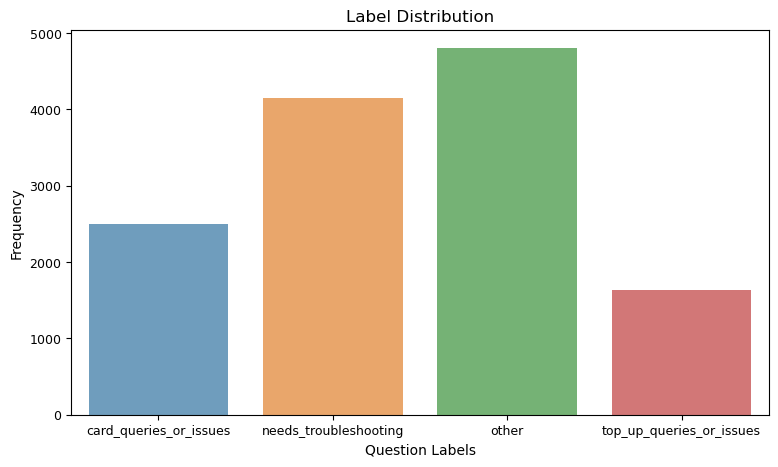

In [41]:
x_label = df1['label'].value_counts()
y_count = x_label.sort_index()
plt.figure(figsize=(9,5))
sns.barplot(x=y_count.index, y=y_count.values, alpha=0.7)
plt.title("Label Distribution", fontsize=12)
plt.ylabel('Frequency', fontsize=10)
plt.yticks(fontsize=9)
plt.xlabel('Question Labels', fontsize=10)
plt.xticks(fontsize=9, rotation=0)
plt.show()

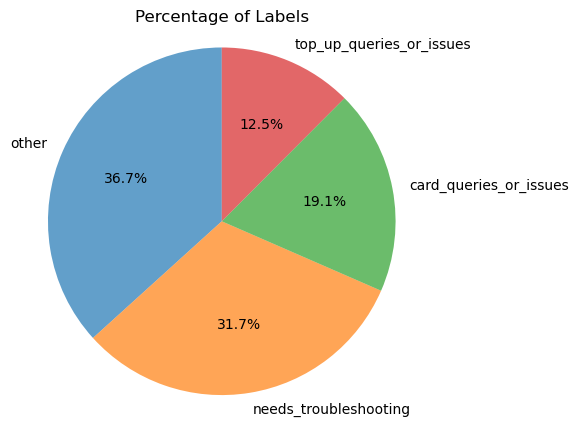

In [42]:
x_label = df1['label'].value_counts()
plt.figure(figsize=(5, 5))
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']
alpha = 0.7
transparent_colors = [(r, g, b, alpha) for r, g, b in plt.cm.tab10.colors]
plt.pie(x_label.values, labels=x_label.index, autopct='%1.1f%%', startangle=90, colors=transparent_colors)
plt.title('Percentage of Labels')
plt.axis('equal')
plt.show()

### Avg. Number of Words per Label

In [43]:
df1['word_count'] = df['text'].apply(lambda x: len(str(x).split()))

In [44]:
df1

,text,label,word_count
0,Can I automatically top-up when traveling?,top_up_queries_or_issues,6
1,What kind of fiat currency can I used for hold...,other,12
2,I did not get the item I ordered. How should ...,other,26
3,Freeze my account it's been hacked.,needs_troubleshooting,6
4,is there a reason that my payment didnt go thr...,other,10
...,...,...,...
14190,Can you tell me what the disposable cards are ...,card_queries_or_issues,11
14191,The ATM won't give me my card back. I need it ...,card_queries_or_issues,13
14192,Can you please tell me why my card payments ar...,card_queries_or_issues,37
14193,The rate for a currency exchange was wrong whe...,needs_troubleshooting,12


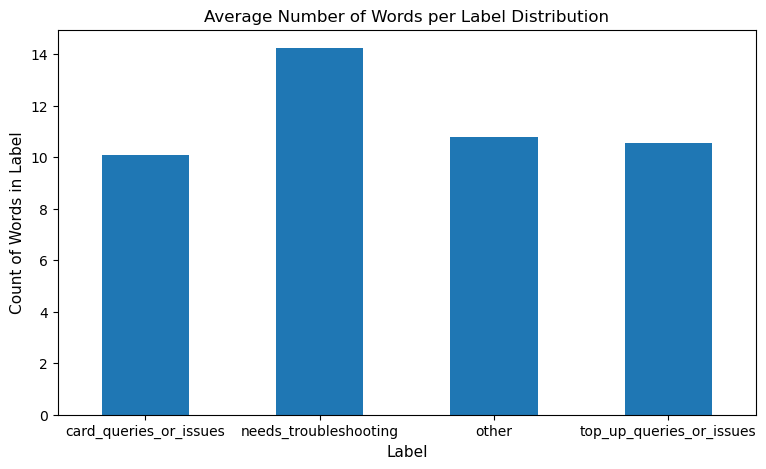

In [45]:
word_avg = df1.groupby('label')['word_count'].mean().plot(kind='bar', figsize=(9,5))
plt.xlabel('Label', fontsize=11)
plt.ylabel('Count of Words in Label', fontsize=11)
plt.xticks(fontsize=10, rotation=0)
plt.yticks(fontsize=10)
plt.title('Average Number of Words per Label Distribution', fontsize=12)
plt.show()

# Data Preprocessing

In [46]:
def preprocess_text(text, use_stemming=False, use_lemmatization=True):
    # Convert to lowercase
    text = text.lower()

    # Remove special characters and digits
    text = re.sub('[^a-zA-Z\s]', '', text)
    text = re.sub('\d+', '', text)

    # Tokenize text
    words = word_tokenize(text)

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]

    # Apply stemming and/or lemmatization
    if use_stemming:
        stemmer = PorterStemmer()
        words = [stemmer.stem(word) for word in words]

    if use_lemmatization:
        lemmatizer = WordNetLemmatizer()
        words = [lemmatizer.lemmatize(word) for word in words]

    # Join words back into a string
    text = ' '.join(words)

    return text


In [47]:
df['text'] = df['text'].apply(preprocess_text)

In [48]:
df

,text,label
0,automatically topup traveling,top_up_queries_or_issues
1,kind fiat currency used holding exchange,other
2,get item ordered go cancel order payment pleas...,other
3,freeze account hacked,needs_troubleshooting
4,reason payment didnt go,other
...,...,...
14190,tell disposable card used,card_queries_or_issues
14191,atm wont give card back need back,card_queries_or_issues
14192,please tell card payment going try buy somethi...,card_queries_or_issues
14193,rate currency exchange wrong bought something,needs_troubleshooting


In [49]:
# Saving the preprocessed dataset.
df.to_csv('../data/final_dataset.csv')

### Word Frequency Analysis after Stop Word Removal and Preprocessing

In [50]:
text_df = df['text']
all_words = []
for wordlist in text_df:
    for word in wordlist.split():
        all_words.append(word)

In [51]:
unique_labels = df['label'].unique()
print(unique_labels)

['top_up_queries_or_issues' 'other' 'needs_troubleshooting'
 'card_queries_or_issues']


In [52]:
df

,text,label
0,automatically topup traveling,top_up_queries_or_issues
1,kind fiat currency used holding exchange,other
2,get item ordered go cancel order payment pleas...,other
3,freeze account hacked,needs_troubleshooting
4,reason payment didnt go,other
...,...,...
14190,tell disposable card used,card_queries_or_issues
14191,atm wont give card back need back,card_queries_or_issues
14192,please tell card payment going try buy somethi...,card_queries_or_issues
14193,rate currency exchange wrong bought something,needs_troubleshooting


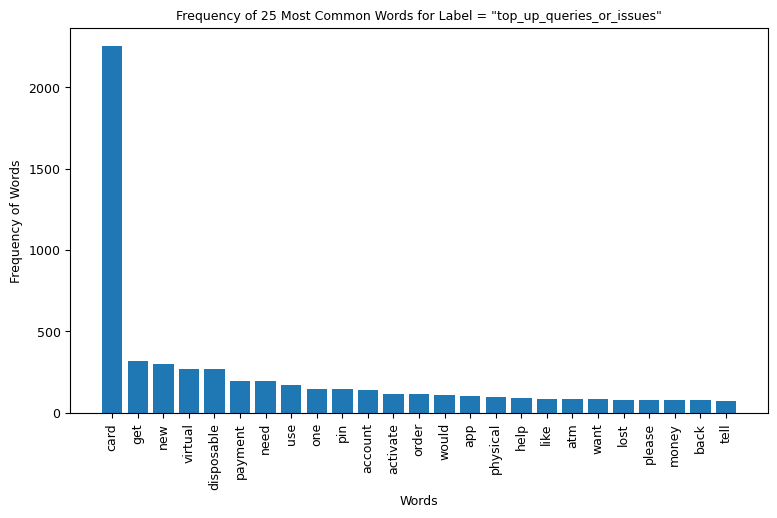

In [53]:
group_by = df.groupby('label')['text'].apply(lambda x: Counter(' '.join(x).split()).most_common(25))
group_by_tag = group_by.iloc[0]
words0 = list(zip(*group_by_tag))[0]
freq0 = list(zip(*group_by_tag))[1]
plt.figure(figsize=(9,5))
plt.bar(words0, freq0)
plt.xlabel('Words', fontsize=9)
plt.ylabel('Frequency of Words', fontsize=9)
plt.yticks(fontsize=9)
plt.xticks(rotation=90, fontsize=9)
plt.title(f'Frequency of 25 Most Common Words for Label = "{unique_labels[0]}"', fontsize=9)
plt.show()

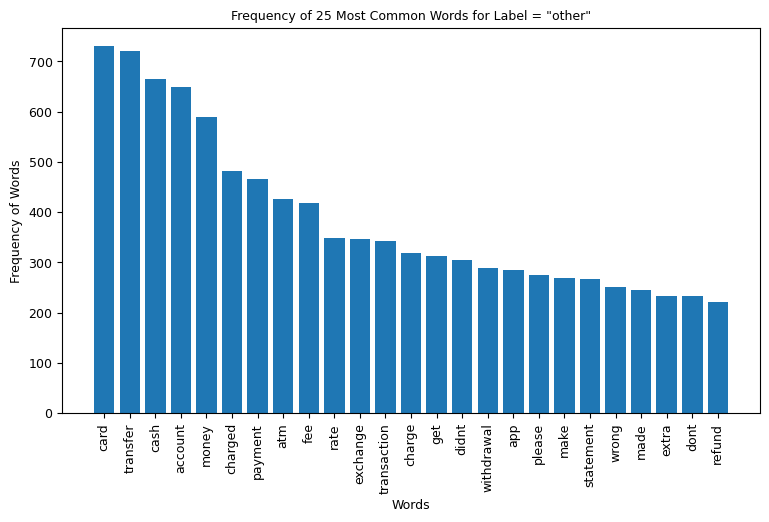

In [54]:
group_by = df.groupby('label')['text'].apply(lambda x: Counter(' '.join(x).split()).most_common(25))
group_by_tag = group_by.iloc[1]
words0 = list(zip(*group_by_tag))[0]
freq0 = list(zip(*group_by_tag))[1]
plt.figure(figsize=(9,5))
plt.bar(words0, freq0)
plt.xlabel('Words', fontsize=9)
plt.ylabel('Frequency of Words', fontsize=9)
plt.yticks(fontsize=9)
plt.xticks(rotation=90, fontsize=9)
plt.title(f'Frequency of 25 Most Common Words for Label = "{unique_labels[1]}"', fontsize=9)
plt.show()

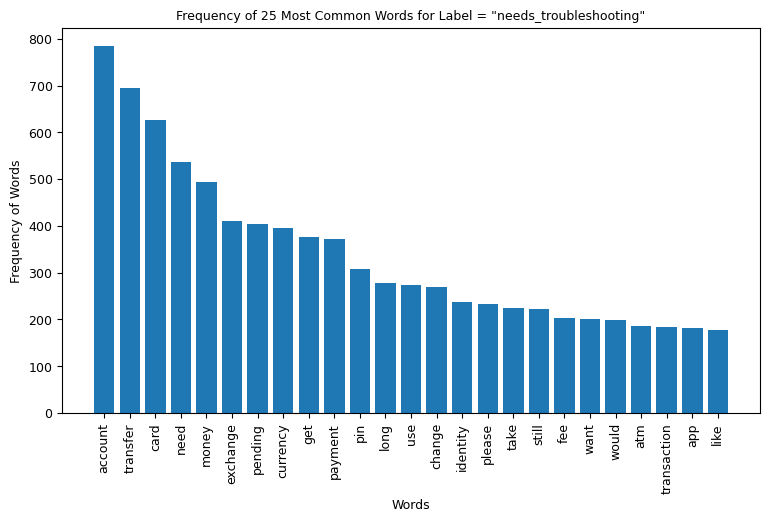

In [55]:
group_by = df.groupby('label')['text'].apply(lambda x: Counter(' '.join(x).split()).most_common(25))
group_by_tag = group_by.iloc[2]
words0 = list(zip(*group_by_tag))[0]
freq0 = list(zip(*group_by_tag))[1]
plt.figure(figsize=(9,5))
plt.bar(words0, freq0)
plt.xlabel('Words', fontsize=9)
plt.ylabel('Frequency of Words', fontsize=9)
plt.yticks(fontsize=9)
plt.xticks(rotation=90, fontsize=9)
plt.title(f'Frequency of 25 Most Common Words for Label = "{unique_labels[2]}"', fontsize=9)
plt.show()

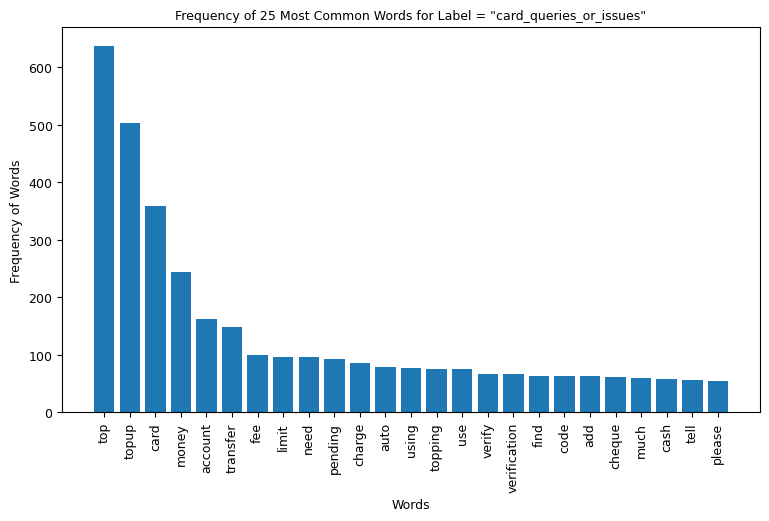

In [56]:
group_by = df.groupby('label')['text'].apply(lambda x: Counter(' '.join(x).split()).most_common(25))
group_by_tag = group_by.iloc[3]
words0 = list(zip(*group_by_tag))[0]
freq0 = list(zip(*group_by_tag))[1]
plt.figure(figsize=(9,5))
plt.bar(words0, freq0)
plt.xlabel('Words', fontsize=9)
plt.ylabel('Frequency of Words', fontsize=9)
plt.yticks(fontsize=9)
plt.xticks(rotation=90, fontsize=9)
plt.title(f'Frequency of 25 Most Common Words for Label = "{unique_labels[3]}"', fontsize=9)
plt.show()

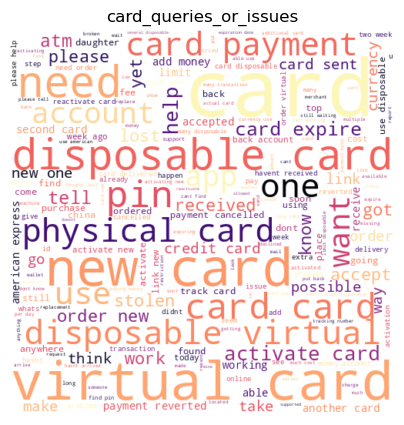

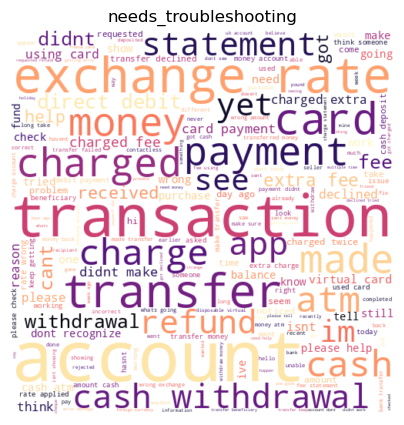

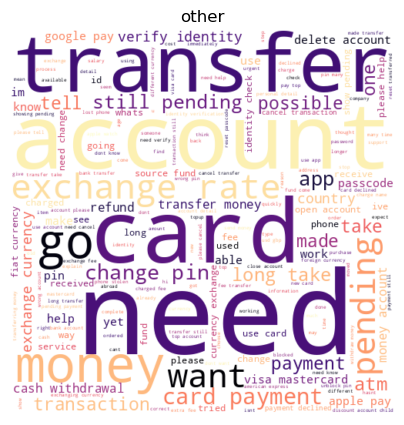

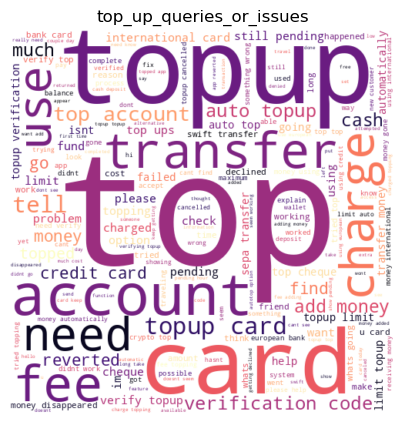

In [57]:
# group the DataFrame by label
grouped = df.groupby('label')

# iterate through each group and generate a wordcloud
for label, group in grouped:
    text = ' '.join(group['text'])
    wordcloud = WordCloud(width=500, height=500, background_color='white', colormap='magma').generate(text)
    plt.figure(figsize=(5,5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(label)
    plt.show()

# Test-Train Split

In [58]:
X = df['text'].copy()
y = df['label'].copy()

# Split the dataset into 80% training data and 20% test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Print the shapes of the split datasets
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

X_train shape: (10467,)
X_test shape: (2617,)
y_train shape: (10467,)
y_test shape: (2617,)


In [59]:
def evaluate_classifier(name, classifier, X_train, y_train, X_test, y_test, save_model=False, n_decimals=4):
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    print('-' * 70)
    print(f'{name.upper()} CLASSIFIER')
    # Print confusion matrix
    print('\nCONFUSION MATRIX', end='\n\n')
    corr_matrix = confusion_matrix(y_test, y_pred, labels=np.unique(y_test))
    print(corr_matrix, end='\n\n')
    print('\nCLASSIFICATION REPORT')
    print(classification_report(y_test, y_pred))
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    print(f"Accuracy: {accuracy:.{n_decimals}f}")
    print(f"Precision: {precision:.{n_decimals}f}")
    print(f"Recall: {recall:.{n_decimals}f}")
    
    # Create a correlation matrix
    fig, ax = plt.subplots(figsize=(5,4))
    sns.heatmap(corr_matrix, annot=True, cmap='Blues', fmt='g', ax=ax)
    ax.set_title(f'{name.upper()} CLASSIFIER CORRELATION MATRIX')
    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')
    plt.show()

    print('-' * 70)
    print('\n')
    
    if save_model:
        with open(f'{name.lower()}_classifier.pkl', 'wb') as f:
            pickle.dump(classifier, f)


# Training with Undersampling

In [60]:
# Perform undersampling on the training set
rus = RandomUnderSampler(random_state=42)
X_train_resampled, y_train_resampled = rus.fit_resample(X_train.to_numpy().reshape(-1, 1), y_train)

In [61]:
X_train_resampled

array([['top debit card'],
       ['pin sent separably'],
       ['speak regarding lost card'],
       ...,
       ['accept check'],
       ['topup verification code visible'],
       ['topup isnt working']], dtype=object)

In [62]:
y_train_resampled

0         card_queries_or_issues
1         card_queries_or_issues
2         card_queries_or_issues
3         card_queries_or_issues
4         card_queries_or_issues
                  ...           
5247    top_up_queries_or_issues
5248    top_up_queries_or_issues
5249    top_up_queries_or_issues
5250    top_up_queries_or_issues
5251    top_up_queries_or_issues
Name: label, Length: 5252, dtype: object

----------------------------------------------------------------------
LOGISTIC REGRESSION CLASSIFIER

CONFUSION MATRIX

[[453  18  20  10]
 [ 33 699  89   2]
 [ 81 110 776   7]
 [  1  10   8 300]]


CLASSIFICATION REPORT
                          precision    recall  f1-score   support

  card_queries_or_issues       0.80      0.90      0.85       501
   needs_troubleshooting       0.84      0.85      0.84       823
                   other       0.87      0.80      0.83       974
top_up_queries_or_issues       0.94      0.94      0.94       319

                accuracy                           0.85      2617
               macro avg       0.86      0.87      0.87      2617
            weighted avg       0.85      0.85      0.85      2617

Accuracy: 0.8514
Precision: 0.8605
Recall: 0.8727


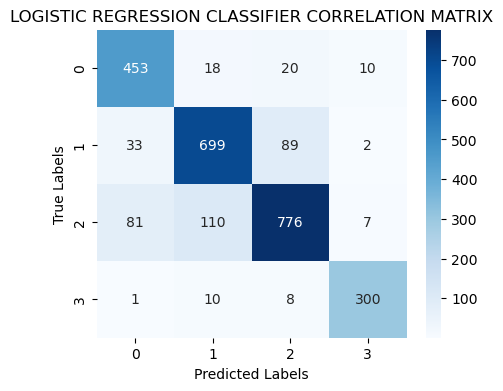

----------------------------------------------------------------------


----------------------------------------------------------------------
NAIVE BAYES CLASSIFIER

CONFUSION MATRIX

[[430  29  24  18]
 [ 28 706  62  27]
 [ 84 142 717  31]
 [  4  14   8 293]]


CLASSIFICATION REPORT
                          precision    recall  f1-score   support

  card_queries_or_issues       0.79      0.86      0.82       501
   needs_troubleshooting       0.79      0.86      0.82       823
                   other       0.88      0.74      0.80       974
top_up_queries_or_issues       0.79      0.92      0.85       319

                accuracy                           0.82      2617
               macro avg       0.81      0.84      0.83      2617
            weighted avg       0.83      0.82      0.82      2617

Accuracy: 0.8200
Precision: 0.8145
Recall: 0.8427


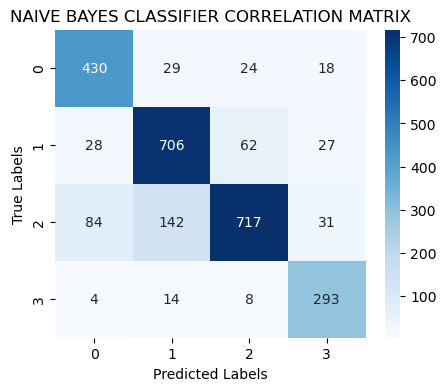

----------------------------------------------------------------------


----------------------------------------------------------------------
SVM CLASSIFIER

CONFUSION MATRIX

[[464   9  21   7]
 [ 39 710  72   2]
 [ 79 104 782   9]
 [  1   9   7 302]]


CLASSIFICATION REPORT
                          precision    recall  f1-score   support

  card_queries_or_issues       0.80      0.93      0.86       501
   needs_troubleshooting       0.85      0.86      0.86       823
                   other       0.89      0.80      0.84       974
top_up_queries_or_issues       0.94      0.95      0.95       319

                accuracy                           0.86      2617
               macro avg       0.87      0.88      0.88      2617
            weighted avg       0.87      0.86      0.86      2617

Accuracy: 0.8628
Precision: 0.8699
Recall: 0.8846


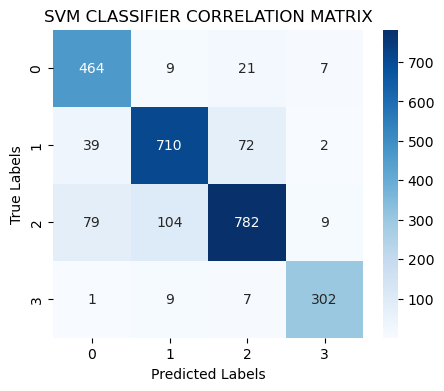

----------------------------------------------------------------------


----------------------------------------------------------------------
ADABOOST CLASSIFIER

CONFUSION MATRIX

[[433  25  34   9]
 [106 412 259  46]
 [174 141 606  53]
 [  5  22  99 193]]


CLASSIFICATION REPORT
                          precision    recall  f1-score   support

  card_queries_or_issues       0.60      0.86      0.71       501
   needs_troubleshooting       0.69      0.50      0.58       823
                   other       0.61      0.62      0.61       974
top_up_queries_or_issues       0.64      0.61      0.62       319

                accuracy                           0.63      2617
               macro avg       0.63      0.65      0.63      2617
            weighted avg       0.64      0.63      0.62      2617

Accuracy: 0.6282
Precision: 0.6345
Recall: 0.6480


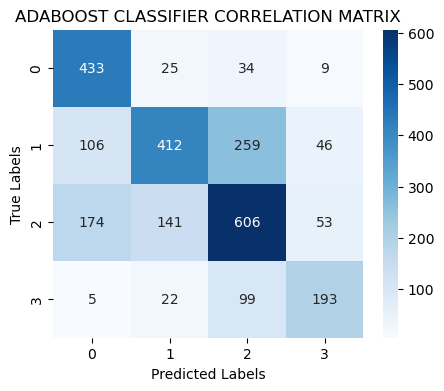

----------------------------------------------------------------------


----------------------------------------------------------------------
RANDOM FOREST CLASSIFIER

CONFUSION MATRIX

[[457  10  23  11]
 [ 34 730  53   6]
 [ 72  51 836  15]
 [  2   7   6 304]]


CLASSIFICATION REPORT
                          precision    recall  f1-score   support

  card_queries_or_issues       0.81      0.91      0.86       501
   needs_troubleshooting       0.91      0.89      0.90       823
                   other       0.91      0.86      0.88       974
top_up_queries_or_issues       0.90      0.95      0.93       319

                accuracy                           0.89      2617
               macro avg       0.88      0.90      0.89      2617
            weighted avg       0.89      0.89      0.89      2617

Accuracy: 0.8892
Precision: 0.8848
Recall: 0.9026


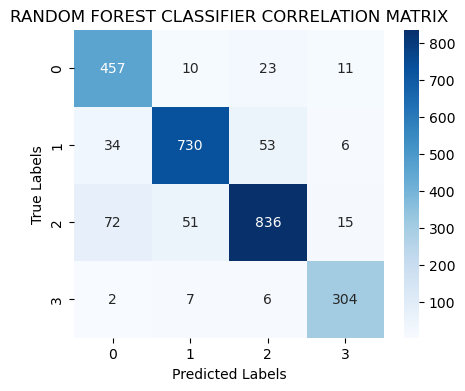

----------------------------------------------------------------------


----------------------------------------------------------------------
GRADIENT BOOSTING CLASSIFIER

CONFUSION MATRIX

[[462   6  21  12]
 [ 74 584 165   0]
 [104  73 785  12]
 [  1   8  15 295]]


CLASSIFICATION REPORT
                          precision    recall  f1-score   support

  card_queries_or_issues       0.72      0.92      0.81       501
   needs_troubleshooting       0.87      0.71      0.78       823
                   other       0.80      0.81      0.80       974
top_up_queries_or_issues       0.92      0.92      0.92       319

                accuracy                           0.81      2617
               macro avg       0.83      0.84      0.83      2617
            weighted avg       0.82      0.81      0.81      2617

Accuracy: 0.8124
Precision: 0.8280
Recall: 0.8406


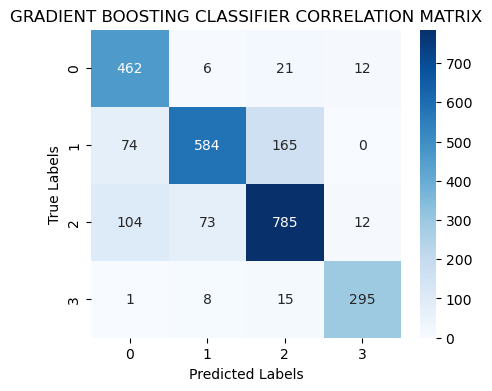

----------------------------------------------------------------------




In [63]:
# Define the classifiers with their corresponding pipelines
classifiers = {
    'logistic regression': Pipeline([('tfidf', TfidfVectorizer()), ('clf', LogisticRegression())]),
    'naive bayes': Pipeline([('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())]),
    'svm': Pipeline([('tfidf', TfidfVectorizer()), ('clf', SVC(kernel='linear'))]),
    'adaboost': Pipeline([('tfidf', TfidfVectorizer()), ('clf', AdaBoostClassifier(n_estimators=300))]),  
    'random forest': Pipeline([('tfidf', TfidfVectorizer()), ('clf', RandomForestClassifier(n_estimators=100, random_state=42))]),
    'gradient boosting': Pipeline([('tfidf', TfidfVectorizer()), ('clf', GradientBoostingClassifier())])
}

# Evaluate each classifier and print evaluation metrics
for name, classifier in classifiers.items():
    evaluate_classifier(name, classifier, X_train_resampled.ravel(), y_train_resampled, X_test, y_test, save_model=True, n_decimals=4)


# Hyperparameter Tuning - Undersampled

Fitting 5 folds for each of 8 candidates, totalling 40 fits
----------------------------------------------------------------------
NAIVE BAYES CLASSIFIER

CONFUSION MATRIX

[[430  29  24  18]
 [ 28 706  62  27]
 [ 84 142 717  31]
 [  4  14   8 293]]


CLASSIFICATION REPORT
                          precision    recall  f1-score   support

  card_queries_or_issues       0.79      0.86      0.82       501
   needs_troubleshooting       0.79      0.86      0.82       823
                   other       0.88      0.74      0.80       974
top_up_queries_or_issues       0.79      0.92      0.85       319

                accuracy                           0.82      2617
               macro avg       0.81      0.84      0.83      2617
            weighted avg       0.83      0.82      0.82      2617

Accuracy: 0.8200
Precision: 0.8145
Recall: 0.8427


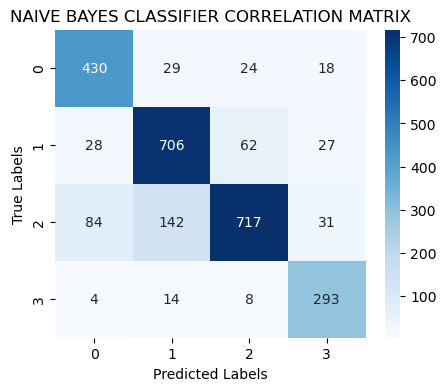

----------------------------------------------------------------------


Fitting 5 folds for each of 12 candidates, totalling 60 fits
----------------------------------------------------------------------
SVM CLASSIFIER

CONFUSION MATRIX

[[455  10  27   9]
 [ 21 743  57   2]
 [ 57  55 854   8]
 [  1   6   8 304]]


CLASSIFICATION REPORT
                          precision    recall  f1-score   support

  card_queries_or_issues       0.85      0.91      0.88       501
   needs_troubleshooting       0.91      0.90      0.91       823
                   other       0.90      0.88      0.89       974
top_up_queries_or_issues       0.94      0.95      0.95       319

                accuracy                           0.90      2617
               macro avg       0.90      0.91      0.91      2617
            weighted avg       0.90      0.90      0.90      2617

Accuracy: 0.9003
Precision: 0.9022
Recall: 0.9102


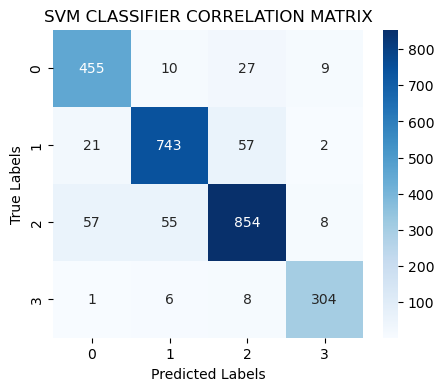

----------------------------------------------------------------------


Fitting 5 folds for each of 9 candidates, totalling 45 fits
----------------------------------------------------------------------
ADABOOST CLASSIFIER

CONFUSION MATRIX

[[433  25  34   9]
 [106 413 258  46]
 [174 141 606  53]
 [  5  22  99 193]]


CLASSIFICATION REPORT
                          precision    recall  f1-score   support

  card_queries_or_issues       0.60      0.86      0.71       501
   needs_troubleshooting       0.69      0.50      0.58       823
                   other       0.61      0.62      0.61       974
top_up_queries_or_issues       0.64      0.61      0.62       319

                accuracy                           0.63      2617
               macro avg       0.63      0.65      0.63      2617
            weighted avg       0.64      0.63      0.62      2617

Accuracy: 0.6286
Precision: 0.6348
Recall: 0.6483


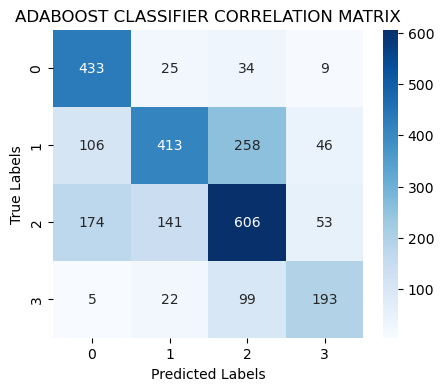

----------------------------------------------------------------------


Fitting 5 folds for each of 81 candidates, totalling 405 fits
----------------------------------------------------------------------
RANDOM FOREST CLASSIFIER

CONFUSION MATRIX

[[441  13  37  10]
 [ 86 630 104   3]
 [107  83 760  24]
 [  7  14  13 285]]


CLASSIFICATION REPORT
                          precision    recall  f1-score   support

  card_queries_or_issues       0.69      0.88      0.77       501
   needs_troubleshooting       0.85      0.77      0.81       823
                   other       0.83      0.78      0.81       974
top_up_queries_or_issues       0.89      0.89      0.89       319

                accuracy                           0.81      2617
               macro avg       0.81      0.83      0.82      2617
            weighted avg       0.82      0.81      0.81      2617

Accuracy: 0.8086
Precision: 0.8140
Recall: 0.8299


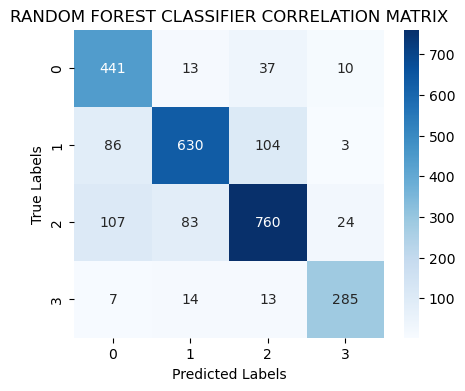

----------------------------------------------------------------------


Fitting 5 folds for each of 27 candidates, totalling 135 fits
----------------------------------------------------------------------
GRADIENT BOOSTING CLASSIFIER

CONFUSION MATRIX

[[463   8  19  11]
 [ 48 696  78   1]
 [ 81  74 808  11]
 [  1   6  11 301]]


CLASSIFICATION REPORT
                          precision    recall  f1-score   support

  card_queries_or_issues       0.78      0.92      0.85       501
   needs_troubleshooting       0.89      0.85      0.87       823
                   other       0.88      0.83      0.86       974
top_up_queries_or_issues       0.93      0.94      0.94       319

                accuracy                           0.87      2617
               macro avg       0.87      0.89      0.88      2617
            weighted avg       0.87      0.87      0.87      2617

Accuracy: 0.8666
Precision: 0.8699
Recall: 0.8857


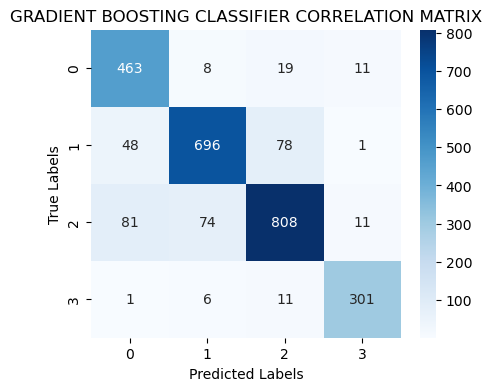

----------------------------------------------------------------------




In [66]:
# Parameters for Logistic Regression
lr_params = {'clf__C': [0.1, 1, 10], 
             'clf__penalty': ['l1', 'l2']}

# Parameters for Multinomial Naive Bayes
nb_params = {'clf__alpha': [0.01, 0.1, 1, 10], 
             'clf__fit_prior': [True, False]}

# Parameters for Support Vector Machine
svm_params = {'clf__C': [0.1, 1, 10], 
              'clf__kernel': ['linear', 'rbf'], 
              'clf__gamma': ['scale', 'auto']}

# Parameters for Random Forest
rf_params = {'clf__n_estimators': [100, 200, 300], 
             'clf__max_depth': [5, 10, 15], 
             'clf__min_samples_split': [2, 5, 10], 
             'clf__min_samples_leaf': [1, 2, 4]}

# Parameters for Gradient Boosting
gb_params = {'clf__n_estimators': [100, 200, 300], 
             'clf__learning_rate': [0.01, 0.1, 1.0], 
             'clf__subsample': [0.5, 0.75, 1.0]}

# Parameters for AdaBoost
ab_params = {'clf__n_estimators': [100, 200, 300], 
             'clf__learning_rate': [0.01, 0.1, 1]}


# Define the classifiers with their corresponding pipelines and hyperparameter grids
classifiers = {
#     'logistic regression': {'pipeline': Pipeline([('tfidf', TfidfVectorizer()), ('clf', LogisticRegression())]), 'params': lr_params},
    'naive bayes': {'pipeline': Pipeline([('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())]), 'params': nb_params},
    'svm': {'pipeline': Pipeline([('tfidf', TfidfVectorizer()), ('clf', SVC(kernel='linear'))]), 'params': svm_params},
    'adaboost': {'pipeline': Pipeline([('tfidf', TfidfVectorizer()), ('clf', AdaBoostClassifier())]), 'params': ab_params},
    'random forest': {'pipeline': Pipeline([('tfidf', TfidfVectorizer()), ('clf', RandomForestClassifier(random_state=42))]), 'params': rf_params},
    'gradient boosting': {'pipeline': Pipeline([('tfidf', TfidfVectorizer()), ('clf', GradientBoostingClassifier())]), 'params': gb_params},
}

best_params = {}

# Evaluate each classifier and print evaluation metrics
for name, classifier in classifiers.items():
    grid_search = GridSearchCV(classifier['pipeline'], classifier['params'], cv=5, n_jobs=-1, verbose=1)
    grid_search.fit(X_train_resampled.ravel(), y_train_resampled)
    best_params[name] = grid_search.best_params_
    clf = classifier['pipeline'].set_params(**grid_search.best_params_)
    evaluate_classifier(name, clf, X_train_resampled.ravel(), y_train_resampled, X_test, y_test, save_model=True, n_decimals=4)

# Save the best parameters for all models
with open('../models/best_params_undersampled.pkl', 'wb') as f:
    pickle.dump(best_params, f)


## Run with best params from the saved file  - Undersampled 

RUN WITH BEST PARAMETERS

----------------------------------------------------------------------
NAIVE BAYES CLASSIFIER

CONFUSION MATRIX

[[430  29  24  18]
 [ 28 706  62  27]
 [ 84 142 717  31]
 [  4  14   8 293]]


CLASSIFICATION REPORT
                          precision    recall  f1-score   support

  card_queries_or_issues       0.79      0.86      0.82       501
   needs_troubleshooting       0.79      0.86      0.82       823
                   other       0.88      0.74      0.80       974
top_up_queries_or_issues       0.79      0.92      0.85       319

                accuracy                           0.82      2617
               macro avg       0.81      0.84      0.83      2617
            weighted avg       0.83      0.82      0.82      2617

Accuracy: 0.8200
Precision: 0.8145
Recall: 0.8427


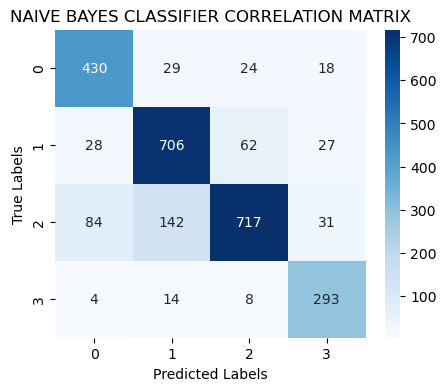

----------------------------------------------------------------------


----------------------------------------------------------------------
SVM CLASSIFIER

CONFUSION MATRIX

[[455  10  27   9]
 [ 21 743  57   2]
 [ 57  55 854   8]
 [  1   6   8 304]]


CLASSIFICATION REPORT
                          precision    recall  f1-score   support

  card_queries_or_issues       0.85      0.91      0.88       501
   needs_troubleshooting       0.91      0.90      0.91       823
                   other       0.90      0.88      0.89       974
top_up_queries_or_issues       0.94      0.95      0.95       319

                accuracy                           0.90      2617
               macro avg       0.90      0.91      0.91      2617
            weighted avg       0.90      0.90      0.90      2617

Accuracy: 0.9003
Precision: 0.9022
Recall: 0.9102


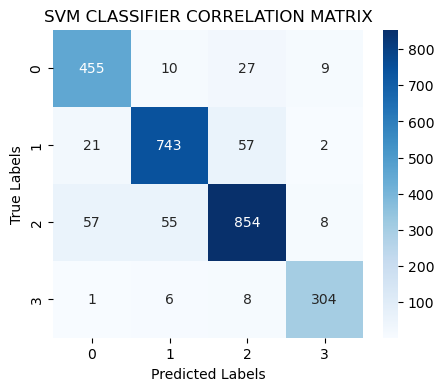

----------------------------------------------------------------------


----------------------------------------------------------------------
ADABOOST CLASSIFIER

CONFUSION MATRIX

[[434  24  36   7]
 [110 341 329  43]
 [172 114 635  53]
 [  5  18 148 148]]


CLASSIFICATION REPORT
                          precision    recall  f1-score   support

  card_queries_or_issues       0.60      0.87      0.71       501
   needs_troubleshooting       0.69      0.41      0.52       823
                   other       0.55      0.65      0.60       974
top_up_queries_or_issues       0.59      0.46      0.52       319

                accuracy                           0.60      2617
               macro avg       0.61      0.60      0.59      2617
            weighted avg       0.61      0.60      0.58      2617

Accuracy: 0.5953
Precision: 0.6077
Recall: 0.5991


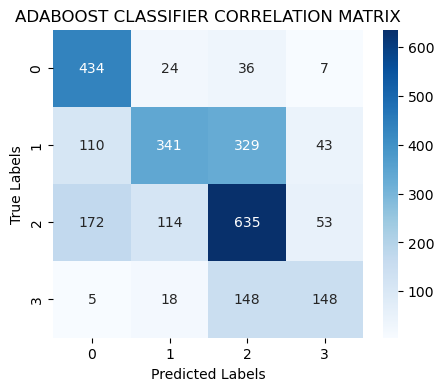

----------------------------------------------------------------------


----------------------------------------------------------------------
RANDOM FOREST CLASSIFIER

CONFUSION MATRIX

[[441  13  37  10]
 [ 86 630 104   3]
 [107  83 760  24]
 [  7  14  13 285]]


CLASSIFICATION REPORT
                          precision    recall  f1-score   support

  card_queries_or_issues       0.69      0.88      0.77       501
   needs_troubleshooting       0.85      0.77      0.81       823
                   other       0.83      0.78      0.81       974
top_up_queries_or_issues       0.89      0.89      0.89       319

                accuracy                           0.81      2617
               macro avg       0.81      0.83      0.82      2617
            weighted avg       0.82      0.81      0.81      2617

Accuracy: 0.8086
Precision: 0.8140
Recall: 0.8299


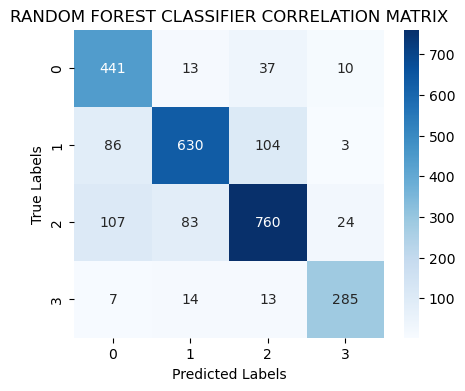

----------------------------------------------------------------------


----------------------------------------------------------------------
GRADIENT BOOSTING CLASSIFIER

CONFUSION MATRIX

[[463   7  22   9]
 [ 48 686  88   1]
 [ 84  83 796  11]
 [  1   6  11 301]]


CLASSIFICATION REPORT
                          precision    recall  f1-score   support

  card_queries_or_issues       0.78      0.92      0.84       501
   needs_troubleshooting       0.88      0.83      0.85       823
                   other       0.87      0.82      0.84       974
top_up_queries_or_issues       0.93      0.94      0.94       319

                accuracy                           0.86      2617
               macro avg       0.86      0.88      0.87      2617
            weighted avg       0.86      0.86      0.86      2617

Accuracy: 0.8582
Precision: 0.8642
Recall: 0.8796


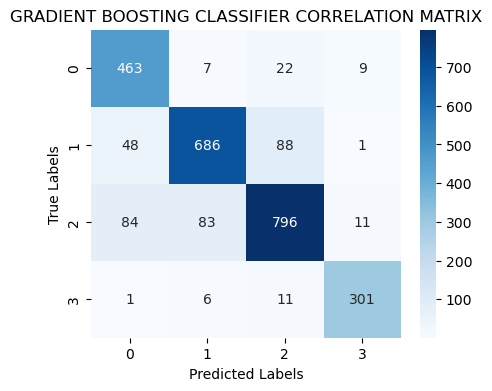

----------------------------------------------------------------------




In [67]:
# Load the best hyperparameters from the saved pickle file
with open('../models/best_params_undersampled.pkl', 'rb') as f:
    best_params = pickle.load(f)

# Define the classifiers with their corresponding pipelines and the best hyperparameters
classifiers = {
#     'logistic regression': {'pipeline': Pipeline([('tfidf', TfidfVectorizer()), ('clf', LogisticRegression(**best_params['logistic regression']))])},
    'naive bayes': {'pipeline': Pipeline([('tfidf', TfidfVectorizer()), ('clf', MultinomialNB(**{k.replace('clf__', ''): v for k, v in best_params['naive bayes'].items()}))])},
    'svm': {'pipeline': Pipeline([('tfidf', TfidfVectorizer()), ('clf', SVC(**{k.replace('clf__', ''): v for k, v in best_params['svm'].items()}))])},
    'adaboost': {'pipeline': Pipeline([('tfidf', TfidfVectorizer()), ('clf', AdaBoostClassifier(**{k.replace('clf__', ''): v for k, v in best_params['adaboost'].items()}))])},
    'random forest': {'pipeline': Pipeline([('tfidf', TfidfVectorizer()), ('clf', RandomForestClassifier(random_state=42, **{k.replace('clf__', ''): v for k, v in best_params['random forest'].items()}))])},
    'gradient boosting': {'pipeline': Pipeline([('tfidf', TfidfVectorizer()), ('clf', GradientBoostingClassifier(**{k.replace('clf__', ''): v for k, v in best_params['gradient boosting'].items()}))])},
}

print('RUN WITH BEST PARAMETERS', end='\n\n')

# Train and evaluate each classifier with the best hyperparameters
for name, classifier in classifiers.items():
    clf = classifier['pipeline']
    clf.fit(X_train_resampled.ravel(), y_train_resampled)
    evaluate_classifier(name, clf, X_train_resampled.ravel(), y_train_resampled, X_test, y_test, save_model=False, n_decimals=4)


# Training with Oversampling

In [72]:
# Perform oversampling on the training set
ros = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train.to_numpy().reshape(-1, 1), y_train)

In [73]:
X_train_resampled

array([['way automatic top'],
       ['money asked asked got'],
       ['virtual card going'],
       ...,
       ['top verification code found'],
       ['money added automatically necessary'],
       ['could explain topup gone yet']], dtype=object)

In [74]:
y_train_resampled

0        top_up_queries_or_issues
1           needs_troubleshooting
2           needs_troubleshooting
3                           other
4                           other
                   ...           
15315    top_up_queries_or_issues
15316    top_up_queries_or_issues
15317    top_up_queries_or_issues
15318    top_up_queries_or_issues
15319    top_up_queries_or_issues
Name: label, Length: 15320, dtype: object

----------------------------------------------------------------------
LOGISTIC REGRESSION CLASSIFIER

CONFUSION MATRIX

[[453  17  25   6]
 [ 35 717  70   1]
 [ 60  94 815   5]
 [  1   6  11 301]]


CLASSIFICATION REPORT
                          precision    recall  f1-score   support

  card_queries_or_issues       0.83      0.90      0.86       501
   needs_troubleshooting       0.86      0.87      0.87       823
                   other       0.88      0.84      0.86       974
top_up_queries_or_issues       0.96      0.94      0.95       319

                accuracy                           0.87      2617
               macro avg       0.88      0.89      0.89      2617
            weighted avg       0.87      0.87      0.87      2617

Accuracy: 0.8735
Precision: 0.8829
Recall: 0.8889


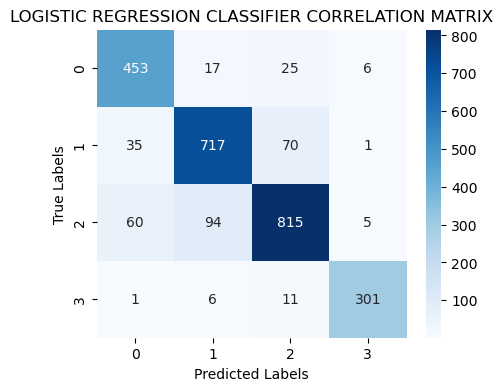

----------------------------------------------------------------------


----------------------------------------------------------------------
NAIVE BAYES CLASSIFIER

CONFUSION MATRIX

[[423  33  30  15]
 [ 20 714  63  26]
 [ 70 135 742  27]
 [  3   8  10 298]]


CLASSIFICATION REPORT
                          precision    recall  f1-score   support

  card_queries_or_issues       0.82      0.84      0.83       501
   needs_troubleshooting       0.80      0.87      0.83       823
                   other       0.88      0.76      0.82       974
top_up_queries_or_issues       0.81      0.93      0.87       319

                accuracy                           0.83      2617
               macro avg       0.83      0.85      0.84      2617
            weighted avg       0.84      0.83      0.83      2617

Accuracy: 0.8319
Precision: 0.8286
Recall: 0.8520


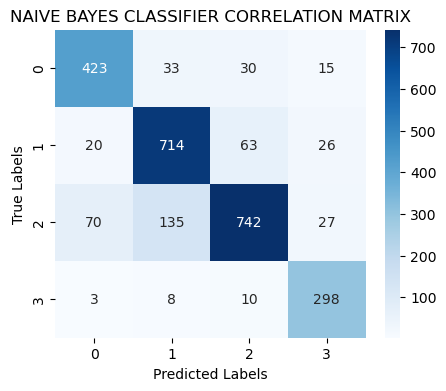

----------------------------------------------------------------------


----------------------------------------------------------------------
SVM CLASSIFIER

CONFUSION MATRIX

[[458  10  27   6]
 [ 37 725  59   2]
 [ 60  92 813   9]
 [  1  11   6 301]]


CLASSIFICATION REPORT
                          precision    recall  f1-score   support

  card_queries_or_issues       0.82      0.91      0.87       501
   needs_troubleshooting       0.87      0.88      0.87       823
                   other       0.90      0.83      0.87       974
top_up_queries_or_issues       0.95      0.94      0.95       319

                accuracy                           0.88      2617
               macro avg       0.88      0.89      0.89      2617
            weighted avg       0.88      0.88      0.88      2617

Accuracy: 0.8777
Precision: 0.8834
Recall: 0.8933


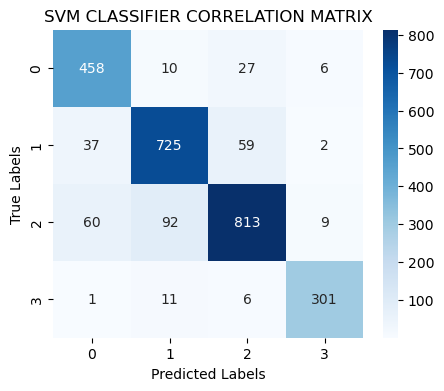

----------------------------------------------------------------------


----------------------------------------------------------------------
ADABOOST CLASSIFIER

CONFUSION MATRIX

[[429  22  48   2]
 [100 325 371  27]
 [203  87 653  31]
 [ 94  11  89 125]]


CLASSIFICATION REPORT
                          precision    recall  f1-score   support

  card_queries_or_issues       0.52      0.86      0.65       501
   needs_troubleshooting       0.73      0.39      0.51       823
                   other       0.56      0.67      0.61       974
top_up_queries_or_issues       0.68      0.39      0.50       319

                accuracy                           0.59      2617
               macro avg       0.62      0.58      0.57      2617
            weighted avg       0.62      0.59      0.57      2617

Accuracy: 0.5854
Precision: 0.6220
Recall: 0.5784


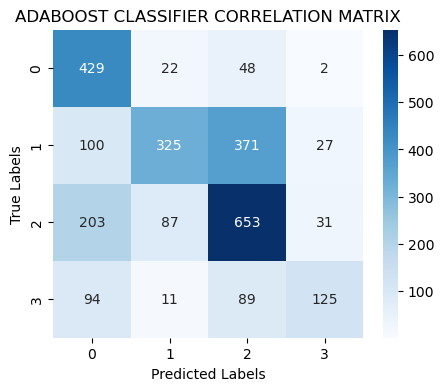

----------------------------------------------------------------------


----------------------------------------------------------------------
RANDOM FOREST CLASSIFIER

CONFUSION MATRIX

[[457  11  26   7]
 [ 20 752  50   1]
 [ 50  34 885   5]
 [  2   8  11 298]]


CLASSIFICATION REPORT
                          precision    recall  f1-score   support

  card_queries_or_issues       0.86      0.91      0.89       501
   needs_troubleshooting       0.93      0.91      0.92       823
                   other       0.91      0.91      0.91       974
top_up_queries_or_issues       0.96      0.93      0.95       319

                accuracy                           0.91      2617
               macro avg       0.92      0.92      0.92      2617
            weighted avg       0.91      0.91      0.91      2617

Accuracy: 0.9140
Precision: 0.9167
Recall: 0.9172


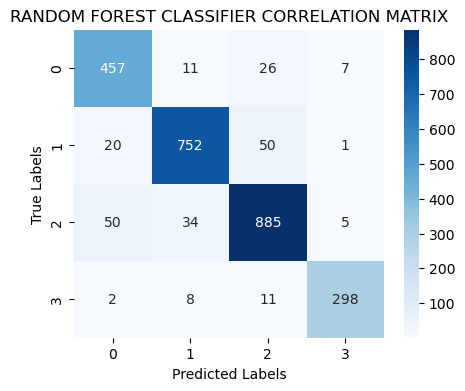

----------------------------------------------------------------------


----------------------------------------------------------------------
GRADIENT BOOSTING CLASSIFIER

CONFUSION MATRIX

[[461   6  23  11]
 [ 69 633 119   2]
 [ 87  85 792  10]
 [  2  10  13 294]]


CLASSIFICATION REPORT
                          precision    recall  f1-score   support

  card_queries_or_issues       0.74      0.92      0.82       501
   needs_troubleshooting       0.86      0.77      0.81       823
                   other       0.84      0.81      0.82       974
top_up_queries_or_issues       0.93      0.92      0.92       319

                accuracy                           0.83      2617
               macro avg       0.84      0.86      0.85      2617
            weighted avg       0.84      0.83      0.83      2617

Accuracy: 0.8330
Precision: 0.8427
Recall: 0.8560


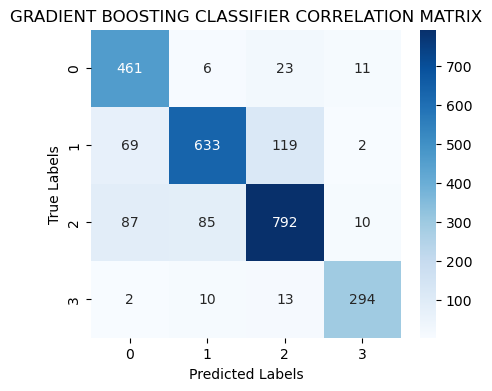

----------------------------------------------------------------------




In [75]:
# Define the classifiers with their corresponding pipelines
classifiers = {
    'logistic regression': Pipeline([('tfidf', TfidfVectorizer()), ('clf', LogisticRegression())]),
    'naive bayes': Pipeline([('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())]),
    'svm': Pipeline([('tfidf', TfidfVectorizer()), ('clf', SVC(kernel='linear'))]),
    'adaboost': Pipeline([('tfidf', TfidfVectorizer()), ('clf', AdaBoostClassifier(n_estimators=300))]),  
    'random forest': Pipeline([('tfidf', TfidfVectorizer()), ('clf', RandomForestClassifier(n_estimators=100, random_state=42))]),
    'gradient boosting': Pipeline([('tfidf', TfidfVectorizer()), ('clf', GradientBoostingClassifier())])
}

# Evaluate each classifier and print evaluation metrics
for name, classifier in classifiers.items():
    evaluate_classifier(name, classifier, X_train_resampled.ravel(), y_train_resampled, X_test, y_test, save_model=False, n_decimals=4)


# Hyperparameter Tuning - Oversampled

Fitting 5 folds for each of 8 candidates, totalling 40 fits
----------------------------------------------------------------------
NAIVE BAYES CLASSIFIER

CONFUSION MATRIX

[[417  34  36  14]
 [ 21 706  71  25]
 [ 61 130 757  26]
 [  5   7  18 289]]


CLASSIFICATION REPORT
                          precision    recall  f1-score   support

  card_queries_or_issues       0.83      0.83      0.83       501
   needs_troubleshooting       0.81      0.86      0.83       823
                   other       0.86      0.78      0.82       974
top_up_queries_or_issues       0.82      0.91      0.86       319

                accuracy                           0.83      2617
               macro avg       0.83      0.84      0.83      2617
            weighted avg       0.83      0.83      0.83      2617

Accuracy: 0.8288
Precision: 0.8268
Recall: 0.8433


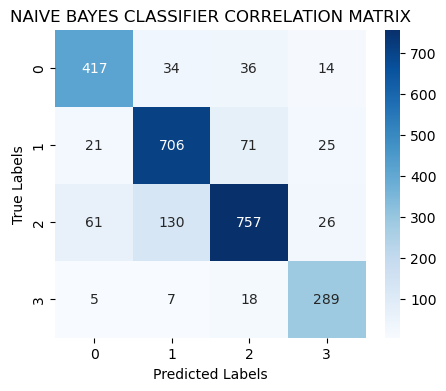

----------------------------------------------------------------------


Fitting 5 folds for each of 12 candidates, totalling 60 fits
----------------------------------------------------------------------
SVM CLASSIFIER

CONFUSION MATRIX

[[459   6  28   8]
 [ 20 753  48   2]
 [ 32  29 910   3]
 [  1   8   7 303]]


CLASSIFICATION REPORT
                          precision    recall  f1-score   support

  card_queries_or_issues       0.90      0.92      0.91       501
   needs_troubleshooting       0.95      0.91      0.93       823
                   other       0.92      0.93      0.93       974
top_up_queries_or_issues       0.96      0.95      0.95       319

                accuracy                           0.93      2617
               macro avg       0.93      0.93      0.93      2617
            weighted avg       0.93      0.93      0.93      2617

Accuracy: 0.9266
Precision: 0.9294
Recall: 0.9288


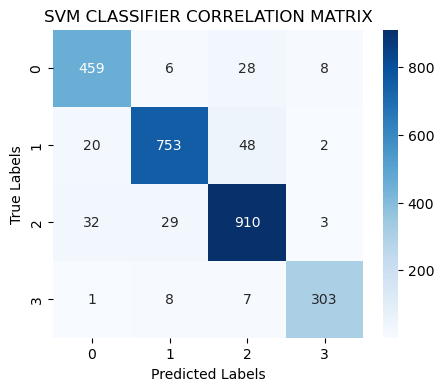

----------------------------------------------------------------------


Fitting 5 folds for each of 9 candidates, totalling 45 fits
----------------------------------------------------------------------
ADABOOST CLASSIFIER

CONFUSION MATRIX

[[429  22  48   2]
 [100 325 371  27]
 [203  87 653  31]
 [ 94  11  89 125]]


CLASSIFICATION REPORT
                          precision    recall  f1-score   support

  card_queries_or_issues       0.52      0.86      0.65       501
   needs_troubleshooting       0.73      0.39      0.51       823
                   other       0.56      0.67      0.61       974
top_up_queries_or_issues       0.68      0.39      0.50       319

                accuracy                           0.59      2617
               macro avg       0.62      0.58      0.57      2617
            weighted avg       0.62      0.59      0.57      2617

Accuracy: 0.5854
Precision: 0.6220
Recall: 0.5784


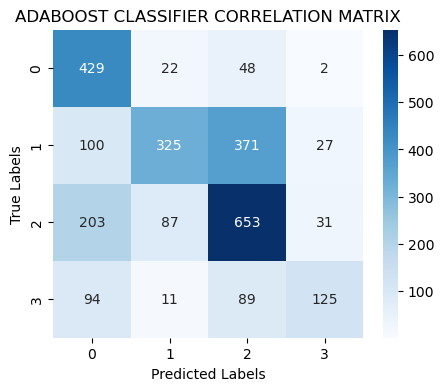

----------------------------------------------------------------------


Fitting 5 folds for each of 81 candidates, totalling 405 fits
----------------------------------------------------------------------
RANDOM FOREST CLASSIFIER

CONFUSION MATRIX

[[441  14  36  10]
 [ 70 661  90   2]
 [103  99 758  14]
 [  4  19  13 283]]


CLASSIFICATION REPORT
                          precision    recall  f1-score   support

  card_queries_or_issues       0.71      0.88      0.79       501
   needs_troubleshooting       0.83      0.80      0.82       823
                   other       0.85      0.78      0.81       974
top_up_queries_or_issues       0.92      0.89      0.90       319

                accuracy                           0.82      2617
               macro avg       0.83      0.84      0.83      2617
            weighted avg       0.82      0.82      0.82      2617

Accuracy: 0.8189
Precision: 0.8270
Recall: 0.8372


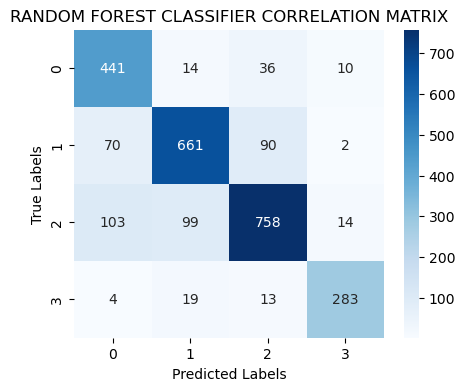

----------------------------------------------------------------------


Fitting 5 folds for each of 27 candidates, totalling 135 fits
----------------------------------------------------------------------
GRADIENT BOOSTING CLASSIFIER

CONFUSION MATRIX

[[444  15  34   8]
 [ 40 706  72   5]
 [ 57  69 839   9]
 [  5  12  15 287]]


CLASSIFICATION REPORT
                          precision    recall  f1-score   support

  card_queries_or_issues       0.81      0.89      0.85       501
   needs_troubleshooting       0.88      0.86      0.87       823
                   other       0.87      0.86      0.87       974
top_up_queries_or_issues       0.93      0.90      0.91       319

                accuracy                           0.87      2617
               macro avg       0.87      0.88      0.87      2617
            weighted avg       0.87      0.87      0.87      2617

Accuracy: 0.8697
Precision: 0.8741
Recall: 0.8763


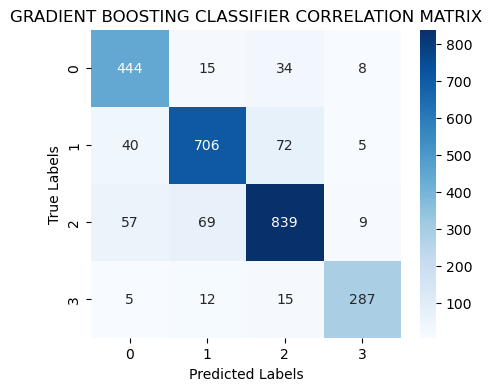

----------------------------------------------------------------------




In [76]:
# Parameters for Logistic Regression
lr_params = {'clf__C': [0.1, 1, 10], 
             'clf__penalty': ['l1', 'l2']}

# Parameters for Multinomial Naive Bayes
nb_params = {'clf__alpha': [0.01, 0.1, 1, 10], 
             'clf__fit_prior': [True, False]}

# Parameters for Support Vector Machine
svm_params = {'clf__C': [0.1, 1, 10], 
              'clf__kernel': ['linear', 'rbf'], 
              'clf__gamma': ['scale', 'auto']}

# Parameters for Random Forest
rf_params = {'clf__n_estimators': [100, 200, 300], 
             'clf__max_depth': [5, 10, 15], 
             'clf__min_samples_split': [2, 5, 10], 
             'clf__min_samples_leaf': [1, 2, 4]}

# Parameters for Gradient Boosting
gb_params = {'clf__n_estimators': [100, 200, 300], 
             'clf__learning_rate': [0.01, 0.1, 1.0], 
             'clf__subsample': [0.5, 0.75, 1.0]}

# Parameters for AdaBoost
ab_params = {'clf__n_estimators': [100, 200, 300], 
             'clf__learning_rate': [0.01, 0.1, 1]}


# Define the classifiers with their corresponding pipelines and hyperparameter grids
classifiers = {
#     'logistic regression': {'pipeline': Pipeline([('tfidf', TfidfVectorizer()), ('clf', LogisticRegression())]), 'params': lr_params},
    'naive bayes': {'pipeline': Pipeline([('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())]), 'params': nb_params},
    'svm': {'pipeline': Pipeline([('tfidf', TfidfVectorizer()), ('clf', SVC(kernel='linear'))]), 'params': svm_params},
    'adaboost': {'pipeline': Pipeline([('tfidf', TfidfVectorizer()), ('clf', AdaBoostClassifier())]), 'params': ab_params},
    'random forest': {'pipeline': Pipeline([('tfidf', TfidfVectorizer()), ('clf', RandomForestClassifier(random_state=42))]), 'params': rf_params},
    'gradient boosting': {'pipeline': Pipeline([('tfidf', TfidfVectorizer()), ('clf', GradientBoostingClassifier())]), 'params': gb_params},
}

best_params = {}

# Evaluate each classifier and print evaluation metrics
for name, classifier in classifiers.items():
    grid_search = GridSearchCV(classifier['pipeline'], classifier['params'], cv=5, n_jobs=-1, verbose=1)
    grid_search.fit(X_train_resampled.ravel(), y_train_resampled)
    best_params[name] = grid_search.best_params_
    clf = classifier['pipeline'].set_params(**grid_search.best_params_)
    evaluate_classifier(name, clf, X_train_resampled.ravel(), y_train_resampled, X_test, y_test, save_model=True, n_decimals=4)

# Save the best parameters for all models
with open('../models/best_params_oversampled.pkl', 'wb') as f:
    pickle.dump(best_params, f)


## Run with best params from the saved file  - Oversampled 

RUN WITH BEST PARAMETERS

----------------------------------------------------------------------
NAIVE BAYES CLASSIFIER

CONFUSION MATRIX

[[417  34  36  14]
 [ 21 706  71  25]
 [ 61 130 757  26]
 [  5   7  18 289]]


CLASSIFICATION REPORT
                          precision    recall  f1-score   support

  card_queries_or_issues       0.83      0.83      0.83       501
   needs_troubleshooting       0.81      0.86      0.83       823
                   other       0.86      0.78      0.82       974
top_up_queries_or_issues       0.82      0.91      0.86       319

                accuracy                           0.83      2617
               macro avg       0.83      0.84      0.83      2617
            weighted avg       0.83      0.83      0.83      2617

Accuracy: 0.8288
Precision: 0.8268
Recall: 0.8433


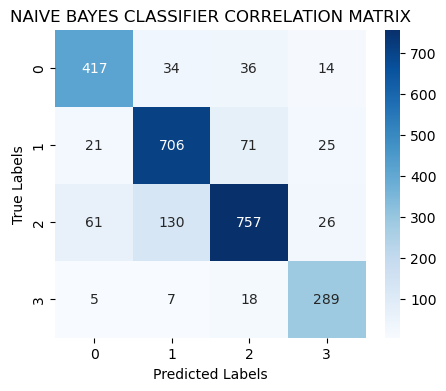

----------------------------------------------------------------------


----------------------------------------------------------------------
SVM CLASSIFIER

CONFUSION MATRIX

[[459   6  28   8]
 [ 20 753  48   2]
 [ 32  29 910   3]
 [  1   8   7 303]]


CLASSIFICATION REPORT
                          precision    recall  f1-score   support

  card_queries_or_issues       0.90      0.92      0.91       501
   needs_troubleshooting       0.95      0.91      0.93       823
                   other       0.92      0.93      0.93       974
top_up_queries_or_issues       0.96      0.95      0.95       319

                accuracy                           0.93      2617
               macro avg       0.93      0.93      0.93      2617
            weighted avg       0.93      0.93      0.93      2617

Accuracy: 0.9266
Precision: 0.9294
Recall: 0.9288


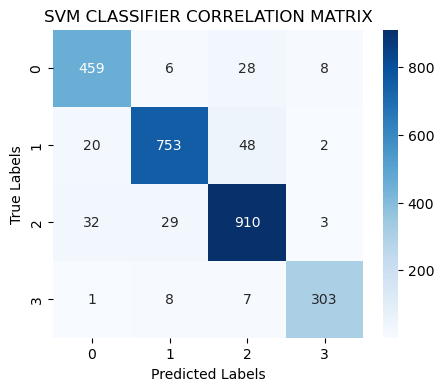

----------------------------------------------------------------------


----------------------------------------------------------------------
ADABOOST CLASSIFIER

CONFUSION MATRIX

[[429  22  48   2]
 [100 325 371  27]
 [203  87 653  31]
 [ 94  11  89 125]]


CLASSIFICATION REPORT
                          precision    recall  f1-score   support

  card_queries_or_issues       0.52      0.86      0.65       501
   needs_troubleshooting       0.73      0.39      0.51       823
                   other       0.56      0.67      0.61       974
top_up_queries_or_issues       0.68      0.39      0.50       319

                accuracy                           0.59      2617
               macro avg       0.62      0.58      0.57      2617
            weighted avg       0.62      0.59      0.57      2617

Accuracy: 0.5854
Precision: 0.6220
Recall: 0.5784


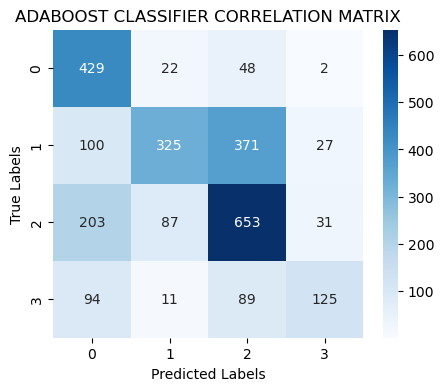

----------------------------------------------------------------------


----------------------------------------------------------------------
RANDOM FOREST CLASSIFIER

CONFUSION MATRIX

[[441  14  36  10]
 [ 70 661  90   2]
 [103  99 758  14]
 [  4  19  13 283]]


CLASSIFICATION REPORT
                          precision    recall  f1-score   support

  card_queries_or_issues       0.71      0.88      0.79       501
   needs_troubleshooting       0.83      0.80      0.82       823
                   other       0.85      0.78      0.81       974
top_up_queries_or_issues       0.92      0.89      0.90       319

                accuracy                           0.82      2617
               macro avg       0.83      0.84      0.83      2617
            weighted avg       0.82      0.82      0.82      2617

Accuracy: 0.8189
Precision: 0.8270
Recall: 0.8372


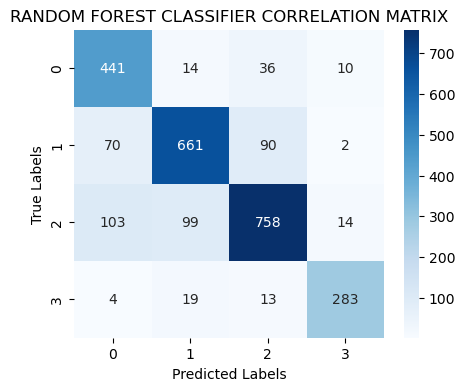

----------------------------------------------------------------------


----------------------------------------------------------------------
GRADIENT BOOSTING CLASSIFIER

CONFUSION MATRIX

[[442  17  35   7]
 [ 36 699  82   6]
 [ 55  72 838   9]
 [  7   7  15 290]]


CLASSIFICATION REPORT
                          precision    recall  f1-score   support

  card_queries_or_issues       0.82      0.88      0.85       501
   needs_troubleshooting       0.88      0.85      0.86       823
                   other       0.86      0.86      0.86       974
top_up_queries_or_issues       0.93      0.91      0.92       319

                accuracy                           0.87      2617
               macro avg       0.87      0.88      0.87      2617
            weighted avg       0.87      0.87      0.87      2617

Accuracy: 0.8670
Precision: 0.8728
Recall: 0.8753


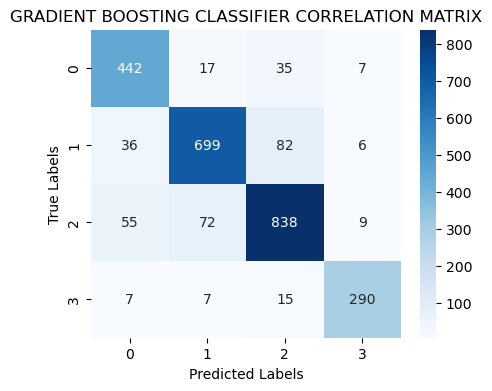

----------------------------------------------------------------------




In [77]:
# Load the best hyperparameters from the saved pickle file
with open('../models/best_params_oversampled.pkl', 'rb') as f:
    best_params = pickle.load(f)

# Define the classifiers with their corresponding pipelines and the best hyperparameters
classifiers = {
#     'logistic regression': {'pipeline': Pipeline([('tfidf', TfidfVectorizer()), ('clf', LogisticRegression(**best_params['logistic regression']))])},
    'naive bayes': {'pipeline': Pipeline([('tfidf', TfidfVectorizer()), ('clf', MultinomialNB(**{k.replace('clf__', ''): v for k, v in best_params['naive bayes'].items()}))])},
    'svm': {'pipeline': Pipeline([('tfidf', TfidfVectorizer()), ('clf', SVC(**{k.replace('clf__', ''): v for k, v in best_params['svm'].items()}))])},
    'adaboost': {'pipeline': Pipeline([('tfidf', TfidfVectorizer()), ('clf', AdaBoostClassifier(**{k.replace('clf__', ''): v for k, v in best_params['adaboost'].items()}))])},
    'random forest': {'pipeline': Pipeline([('tfidf', TfidfVectorizer()), ('clf', RandomForestClassifier(random_state=42, **{k.replace('clf__', ''): v for k, v in best_params['random forest'].items()}))])},
    'gradient boosting': {'pipeline': Pipeline([('tfidf', TfidfVectorizer()), ('clf', GradientBoostingClassifier(**{k.replace('clf__', ''): v for k, v in best_params['gradient boosting'].items()}))])},
}

print('RUN WITH BEST PARAMETERS', end='\n\n')

# Train and evaluate each classifier with the best hyperparameters
for name, classifier in classifiers.items():
    clf = classifier['pipeline']
    clf.fit(X_train_resampled.ravel(), y_train_resampled)
    evaluate_classifier(name, clf, X_train_resampled.ravel(), y_train_resampled, X_test, y_test, save_model=False, n_decimals=4)


## View the best parameters after Hyper-Parameter tuning - Undersampled

In [80]:
temp_best_params = {}
with open('../models/best_params_undersampled.pkl', 'rb') as f:
    temp_best_params = pickle.load(f)

# Display the contents of the best_params dictionary
for classifier, params in temp_best_params.items():
    print(classifier)
    print(params)

naive bayes
{'clf__alpha': 1, 'clf__fit_prior': True}
svm
{'clf__C': 10, 'clf__gamma': 'scale', 'clf__kernel': 'rbf'}
adaboost
{'clf__learning_rate': 1, 'clf__n_estimators': 300}
random forest
{'clf__max_depth': 15, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 2, 'clf__n_estimators': 300}
gradient boosting
{'clf__learning_rate': 0.1, 'clf__n_estimators': 300, 'clf__subsample': 0.75}


## View the best parameters after Hyper-Parameter tuning - Oversampled

In [81]:
temp_best_params = {}
with open('../models/best_params_oversampled.pkl', 'rb') as f:
    temp_best_params = pickle.load(f)

# Display the contents of the best_params dictionary
for classifier, params in temp_best_params.items():
    print(classifier)
    print(params)

naive bayes
{'clf__alpha': 0.1, 'clf__fit_prior': True}
svm
{'clf__C': 10, 'clf__gamma': 'scale', 'clf__kernel': 'rbf'}
adaboost
{'clf__learning_rate': 1, 'clf__n_estimators': 300}
random forest
{'clf__max_depth': 15, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 2, 'clf__n_estimators': 300}
gradient boosting
{'clf__learning_rate': 1.0, 'clf__n_estimators': 300, 'clf__subsample': 1.0}
